# EUKARYA

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# import packages
import os
import re

import dokdo
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qiime2 as q2
from qiime2.plugins import feature_classifier, feature_table
from qiime2.plugins.metadata.visualizers import tabulate
from qiime2.plugins.taxa.methods import filter_seqs, filter_table
from qiime2.plugins.taxa.visualizers import barplot

In [10]:
# define workdir
%env WORKDIR /home/nezapa/qiime-thesis
WORKDIR = os.environ.get("WORKDIR")

env: WORKDIR=/home/nezapa/qiime-thesis


In [11]:
# import data
denoisetable = q2.Artifact.load('./results/denoisetable.qza')
rep_seqs = q2.Artifact.load('./results/rep_seqs.qza')
denoising_stats = q2.Artifact.load('./results/denoising_stats.qza')
sample_metadata = q2.Metadata.load('../00.sample-metadata.tsv')

In [12]:
# view denoising stats
stats_df = denoising_stats.view(q2.Metadata).to_dataframe()
stats_df
#stats_df.sort_values('percentage of input passed filter')
stats_df.sort_values('percentage of input non-chimeric')

,input,filtered,percentage of input passed filter,denoised,non-chimeric,percentage of input non-chimeric
sample-id,,,,,,
P19A,23977.0,20897.0,87.15,20811.0,20753.0,86.55
P22A,39904.0,37579.0,94.17,37339.0,35340.0,88.56
P01A,49871.0,47374.0,94.99,46615.0,44604.0,89.44
P05A,23073.0,22118.0,95.86,21937.0,21117.0,91.52
P07A,21077.0,19843.0,94.15,19657.0,19359.0,91.85
P21A,23275.0,21656.0,93.04,21540.0,21395.0,91.92
P15A,15637.0,14788.0,94.57,14682.0,14502.0,92.74
P13A,28469.0,26808.0,94.17,26566.0,26435.0,92.86
P03A,31396.0,29770.0,94.82,29414.0,29249.0,93.16


In [13]:
# summarise and visualise
feature_table.visualizers.summarize(
    table = denoisetable,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 9da2fe45-a8b7-4de6-b333-e0869a80a8d8>

## TAXONOMIC ANALYSIS

In [14]:
# # load classifier data, eukarya classifier classifier-E-18S616F_18S1132R
# classifier = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/classifier-E-18S616F_18S1132R.qza')
# reference_reads = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/ref-seqs_18S616F_18S1132R.qza')
# reference_taxonomy = q2.Artifact.load(f'{WORKDIR}/database/200827SILVA138/silva-138-99-tax.qza')

In [15]:
# define model choices
models = {
    'sklearn': feature_classifier.methods.classify_sklearn,
    'vsearch': feature_classifier.methods.classify_consensus_vsearch,
    'blast': feature_classifier.methods.classify_consensus_blast,
    'hybrid': feature_classifier.pipelines.classify_hybrid_vsearch_sklearn
}

In [16]:
# choose model, run for each model_name
model_name = "hybrid"
model = models[model_name]

In [17]:
# classify the seqences using different classifiers
# run once for each model
# this step might take some time

if os.path.exists(f'./results/taxonomy_{model_name}.qza'):
    taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')
else:
    if model_name == "sklearn":
        taxonomy = model(
            reads = rep_seqs,
            classifier = classifier,
            n_jobs=4
        )
        
    elif model_name == "vsearch":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            threads = 15
        )
    elif model_name == "blast":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy
            )
    elif model_name == "hybrid":
        taxonomy = model(
            query = rep_seqs,
            reference_reads = reference_reads,
            reference_taxonomy = reference_taxonomy,
            classifier = classifier,
            threads = 2,
            prefilter = False
            )
    else:
        print(f"model name {model_name} doesn't exist")
    
    taxonomy = taxonomy.classification
    taxonomy.save(f'./results/taxonomy_{model_name}.qza')

In [18]:
# merge all taxonomy classifications
for idx, model_name in enumerate(models.keys()):
    model_df = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza').view(pd.DataFrame)
    model_df.columns = [f'{col}_{model_name}' for col in model_df.columns]
    if idx == 0:
        res_df = model_df.copy()
    else:
        res_df = res_df.merge(model_df, on = 'Feature ID')

In [19]:
# view merged df as q2 viz
res_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(res_df)).visualization
res_df_viz.save('./results/res_df_viz.qzv')
res_df_viz

<visualization: Visualization uuid: d103f9c1-98ea-4966-aaf2-30dcddb58e64>

In [20]:
# choose a classifier
model_name = "sklearn"
taxonomy = q2.Artifact.load(f'./results/taxonomy_{model_name}.qza')

In [21]:
# load classification results of a chosen classifier as metadata and view them
taxonomy_metadata = taxonomy.view(q2.Metadata)  # or pd.DataFrame
q2.plugins.metadata.visualizers.tabulate(taxonomy_metadata).visualization

<visualization: Visualization uuid: 22c5426a-ee9d-404a-b021-ceab824e9a22>

In [22]:
### FILTER BY TAXONOMY# load rep_seqs as metadata
rep_seqs_mtdt = rep_seqs.view(q2.Metadata)

# merge dataframes in the background (appends new column)
annotated_taxonomy_metadata = taxonomy_metadata.merge(rep_seqs_mtdt)

# visualize merged dataframes as metadata viz
q2.plugins.metadata.visualizers.tabulate(annotated_taxonomy_metadata).visualization

<visualization: Visualization uuid: 7c2f40e4-e035-4d65-87f9-190a342f5250>

### FILTER BY TAXONOMY

In [23]:
# filter denoisetable, keep only d__Eukaryota
denoisetable_eu = filter_table(
    table = denoisetable,
    taxonomy = taxonomy, 
    include = 'd__Eukaryota'
)
denoisetable_eu.filtered_table.save('./results/denoisetable_eu.qza')

'./results/denoisetable_eu.qza'

In [24]:
# summarise and visualise
feature_table.visualizers.summarize(
    table = denoisetable_eu.filtered_table,
    sample_metadata = sample_metadata
).visualization

<visualization: Visualization uuid: 81693caf-ac62-4b2c-bb5e-9ded075b5310>

In [25]:
# filter rep_seqs, keep only d__Eukaryota

rep_seqs_eu = filter_seqs(
    sequences = rep_seqs,
    taxonomy = taxonomy,
    include = 'd__Eukaryota'
)
rep_seqs_eu.filtered_sequences.save('./results/rep_seqs_eu.qza')

/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_taxa/_method.py:121: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  return sequences[ids_to_keep]
/home/npajek/miniconda3/envs/qiime2-2022.2/lib/python3.8/site-packages/q2_types/feature_data/_transformer.py:254: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id_, seq in data.iteritems():


'./results/rep_seqs_eu.qza'

### TAXA PER SPECIMEN

In [26]:
# load denoise as dataframe and transpose (feature id is index), add name to index
denoise_df = denoisetable_eu.filtered_table.view(view_type = pd.DataFrame).T
denoise_df.index.name = 'id'

# load annotated data as df
annotated_df = annotated_taxonomy_metadata.to_dataframe()

# merge the two using indices of both dataframes
merged_df = denoise_df.merge(annotated_df['Taxon'], left_index=True, right_index=True)

# set Taxon column as index and show transposed
taxon_df = merged_df.set_index('Taxon').T

In [27]:
# define functions
# define extract lvl using regex (regular expressions)
import re
def extract_level(tax, level_prefix, null_data = '/'):
    g = re.findall(fr'({level_prefix}[^;|^$]*)(?=;|$)', tax)
    if len(g) == 0:
        return null_data
    
    return g[0].replace(level_prefix, '')

# define backtrace_unassigned 
def backtrace_unassigned(row, unassigned_like_words, invalid_words):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        valid_name = [val for val in row[columns].values if val not in invalid_words][-1]
        row[columns] = [val if val not in invalid_words else f"Unclass. {valid_name}" for val in row[columns].values]
        
        valid_name = [val for val in row[columns].values if val not in unassigned_like_words][-1]
        row[columns] = [val if val not in unassigned_like_words else f"Unclass. {valid_name}_{val}" for val in row[columns].values]
    except:
        pass
    return row

# define reassemble taxon column
def reassemble_taxon(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    prefixes = ['d__', 'p__', 'c__', 'o__', 'f__', 'g__']
    return ";".join(["".join(pair) for pair in zip(prefixes, row[columns].values)])


# remove duplicates
def remove_duplicates(row):
    columns = ['Domain', 'Phylum', 'Class', 'Order', 'Family', 'Genus']
    try:
        values = [val for val in row[columns].values if "Unclass." not in val]
        unique_values, counts = np.unique(values, return_counts=True)
        duplicate_id = np.where(counts > 1)[0][0] if any(counts > 1) else None
        
        if duplicate_id is not None:
            count = counts[duplicate_id]
            duplicate_str = unique_values[duplicate_id]
            joined_str = '|'.join(row[columns].values[::-1])
            row[columns] = re.sub(duplicate_str, f'Unclass. {duplicate_str}', joined_str, count=count-1).split('|')[::-1]
    except:
        pass
    return row

In [28]:
# run once for each sample (subject)
# choose a sample 
subject = 'P22A'
taxon_df.loc[[subject]].T.reset_index().query(f'{subject} > 0.0').value_counts('Taxon')

# define custom_df, get rid of Unassigned
custom_df = taxon_df.loc[[subject]].T.reset_index()
custom_df = custom_df.query(f'Taxon != "Unassigned" and {subject} > 0')

custom_df['Domain'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='d__', null_data='Unassigned'))
custom_df['Phylum'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='p__', null_data='Unassigned'))
custom_df['Class'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='c__', null_data='Unassigned'))
custom_df['Order'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='o__', null_data='Unassigned'))
custom_df['Family'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='f__', null_data='Unassigned'))
custom_df['Genus'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='g__', null_data='Unassigned'))
#custom_df['Species'] = custom_df.Taxon.apply(lambda tax: extract_level(tax, level_prefix='s__'))

invalid_words = ["uncultured", "Unassigned"]
unassigned_like_words = ['P34.45', 'WD2101_soil_group']
custom_df = custom_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

custom_df['Taxon'] = custom_df.apply(reassemble_taxon, axis=1)
custom_df = custom_df.apply(remove_duplicates, axis=1)

columns = ['Phylum', 'Class', 'Order', 'Family', 'Genus']#, 'Species']
# columns = ['Order', 'Family', 'Genus', 'Species']
taxa_per_species = custom_df.groupby(columns).sum()
taxa_per_species[subject] /= taxa_per_species[subject].sum()
taxa_per_species[subject] = [f'{x*100:.3f}' for x in taxa_per_species[subject]]

# table content for latex
print(taxa_per_species.to_latex(escape=False))

#taxa_per_species

\begin{tabular}{llllll}
\toprule
           &          &                   &                   &                   &    P22A \\
Phylum & Class & Order & Family & Genus &         \\
\midrule
Cercozoa & Incertae_Sedis & Unclass. Incertae_Sedis & Unclass. Incertae_Sedis & Gymnophrys &   1.358 \\
Diatomea & Bacillariophyceae & Unclass. Bacillariophyceae & Unclass. Bacillariophyceae & Cocconeis &   6.635 \\
Mollusca & Gastropoda & Heterobranchia & Unclass. Heterobranchia & Unclass. Heterobranchia &   0.257 \\
Nematozoa & Chromadorea & Monhysterida & Unclass. Monhysterida & Unclass. Monhysterida &   1.334 \\
Platyhelminthes & Monogenea & Monopisthocotylea & Gyrodactylidae & Unclass. Gyrodactylidae &   0.053 \\
Unclass. Eukaryota & Unclass. Eukaryota & Unclass. Eukaryota & Unclass. Eukaryota & Unclass. Eukaryota &   0.306 \\
Vertebrata & Amphibia & Unclass. Amphibia & Unclass. Amphibia & Unclass. Amphibia &  90.057 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_25891/531805109.py:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  taxa_per_species = custom_df.groupby(columns).sum()
/tmp/ipykernel_25891/531805109.py:32: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(taxa_per_species.to_latex(escape=False))


### test za črne

In [72]:
# view denoisetable as dataframe
denoisetable_df = denoisetable_eu.filtered_table.view(view_type=pd.DataFrame)
# drop white specimen & transpose
denoisetable_b_unfiltered = denoisetable_df.tail(4).T
# set index name
denoisetable_b_unfiltered.index.name = 'Feature ID'
# drop rows with all zeros
denoisetable_b= denoisetable_b_unfiltered.loc[(denoisetable_b_unfiltered != 0).any(axis=1)]
# show
denoisetable_b

,P19A,P20A,P21A,P22A
Feature ID,,,,
378956473833ac867536e6ce86dd28ad,0.0,152.0,275.0,0.0
c9726062d776a2f2c9ef3477149ad1f9,0.0,60.0,0.0,0.0
17df485971ea9e715fd79d63623e5184,230.0,0.0,0.0,0.0
9cee0168f109e617cc3246de521fb0dd,3.0,283.0,12.0,0.0
4505ba71ed86adb9e00197251c04d6e1,3.0,3.0,26.0,0.0
...,...,...,...,...
d25f0b7e5f290736e2049b3b30b786f7,0.0,0.0,0.0,275.0
cff69bcacdce506fa0974fbddca19687,57.0,0.0,0.0,0.0
6320dbcb2bd0dd5c48c38b3c1a95fc51,0.0,29.0,0.0,0.0


In [73]:
# view taxonomy metadata as dataframe
taxonomy_metadata = taxonomy.view(q2.Metadata).to_dataframe()
# taxonomy_metadata

# merge denoisetable_b and taxonomy_metadata by Feature ID
merged_df = pd.merge(denoisetable_b, taxonomy_metadata, on="Feature ID")
# merged_df

## view merged_df as q2.viz
merged_df_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(merged_df)).visualization
merged_df_viz

# change column order
cols = merged_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
merged_df = merged_df[cols]
merged_df

,Taxon,Confidence,P19A,P20A,P21A,P22A
Feature ID,,,,,,
378956473833ac867536e6ce86dd28ad,d__Eukaryota; p__Vertebrata; c__Amphibia; o__A...,0.9908496498655958,0.0,152.0,275.0,0.0
c9726062d776a2f2c9ef3477149ad1f9,d__Eukaryota; p__Vertebrata; c__Amphibia; o__A...,0.9326391022711884,0.0,60.0,0.0,0.0
17df485971ea9e715fd79d63623e5184,d__Eukaryota; p__Vertebrata; c__Amphibia; o__A...,0.9717323496158918,230.0,0.0,0.0,0.0
9cee0168f109e617cc3246de521fb0dd,d__Eukaryota; p__Vertebrata,0.9999683837837474,3.0,283.0,12.0,0.0
4505ba71ed86adb9e00197251c04d6e1,d__Eukaryota; p__Vertebrata,0.9979057069867461,3.0,3.0,26.0,0.0
...,...,...,...,...,...,...
d25f0b7e5f290736e2049b3b30b786f7,d__Eukaryota; p__Nematozoa; c__Chromadorea; o_...,0.9999905428648904,0.0,0.0,0.0,275.0
cff69bcacdce506fa0974fbddca19687,d__Eukaryota; p__Vertebrata; c__Amphibia; o__A...,0.9754061388240036,57.0,0.0,0.0,0.0
6320dbcb2bd0dd5c48c38b3c1a95fc51,d__Eukaryota; p__Vertebrata; c__Amphibia; o__A...,0.9868198640223593,0.0,29.0,0.0,0.0


In [74]:
# prepare new_taxonomy file with taxonomy corrections, same as above

merged_df['Domain'] = merged_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
merged_df['Phylum'] = merged_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
merged_df['Class'] = merged_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
merged_df['Order'] = merged_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
merged_df['Family'] = merged_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
merged_df['Genus'] = merged_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ["uncultured", "Unassigned"]
unassigned_like_words = ['P34.45', 'WD2101_soil_group']
merged_df = merged_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

merged_df['Taxon'] = merged_df.apply(reassemble_taxon, axis=1)
merged_df = merged_df.apply(remove_duplicates, axis=1)

new_merged = q2.Artifact.import_data("FeatureData[Taxonomy]", merged_df)
merged_viz = q2.plugins.metadata.visualizers.tabulate(q2.Metadata(merged_df)).visualization
merged_viz

<visualization: Visualization uuid: 6f076d50-a153-4c6f-b773-ac7d37426a9d>

In [75]:
new_merged_df = new_merged.view(view_type = pd.DataFrame)
new_merged_df

,Taxon,Confidence,P19A,P20A,P21A,P22A,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,,,,,
378956473833ac867536e6ce86dd28ad,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Amph...,0.9908496498655958,0.0,152.0,275.0,0.0,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
c9726062d776a2f2c9ef3477149ad1f9,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Amph...,0.9326391022711884,0.0,60.0,0.0,0.0,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
17df485971ea9e715fd79d63623e5184,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Amph...,0.9717323496158918,230.0,0.0,0.0,0.0,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
9cee0168f109e617cc3246de521fb0dd,d__Eukaryota;p__Vertebrata;c__Unclass. Vertebr...,0.9999683837837474,3.0,283.0,12.0,0.0,Eukaryota,Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata
4505ba71ed86adb9e00197251c04d6e1,d__Eukaryota;p__Vertebrata;c__Unclass. Vertebr...,0.9979057069867461,3.0,3.0,26.0,0.0,Eukaryota,Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata
...,...,...,...,...,...,...,...,...,...,...,...,...
d25f0b7e5f290736e2049b3b30b786f7,d__Eukaryota;p__Nematozoa;c__Chromadorea;o__Mo...,0.9999905428648904,0.0,0.0,0.0,275.0,Eukaryota,Nematozoa,Chromadorea,Monhysterida,Unclass. Monhysterida,Unclass. Monhysterida
cff69bcacdce506fa0974fbddca19687,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Amph...,0.9754061388240036,57.0,0.0,0.0,0.0,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
6320dbcb2bd0dd5c48c38b3c1a95fc51,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Amph...,0.9868198640223593,0.0,29.0,0.0,0.0,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia


In [76]:
new_merged_df = new_merged_df[new_merged_df["Phylum"].str.contains("Vertebrata") == False]
new_merged_df

,Taxon,Confidence,P19A,P20A,P21A,P22A,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,,,,,
9bbec49bd6e23372a2613610a5c2fe8a,d__Eukaryota;p__Diatomea;c__Bacillariophyceae;...,0.994482879402258,0.0,0.0,0.0,25.0,Eukaryota,Diatomea,Bacillariophyceae,Unclass. Bacillariophyceae,Unclass. Bacillariophyceae,Cocconeis
2ac90a7558b35fabcb292b0912086d2a,d__Eukaryota;p__Cercozoa;c__Incertae_Sedis;o__...,0.7810968946043947,0.0,0.0,0.0,280.0,Eukaryota,Cercozoa,Incertae_Sedis,Unclass. Incertae_Sedis,Unclass. Incertae_Sedis,Gymnophrys
b721b4328f3dee8d084006c99c2697c2,d__Eukaryota;p__Unclass. Eukaryota;c__Unclass....,0.9999999999999885,0.0,0.0,0.0,63.0,Eukaryota,Unclass. Eukaryota,Unclass. Eukaryota,Unclass. Eukaryota,Unclass. Eukaryota,Unclass. Eukaryota
9879093aa4a399313ec90efc8bc1c337,d__Eukaryota;p__Platyhelminthes;c__Monogenea;o...,0.8734461051448057,0.0,13.0,13.0,11.0,Eukaryota,Platyhelminthes,Monogenea,Monopisthocotylea,Gyrodactylidae,Unclass. Gyrodactylidae
d0155b914863404adae305603660aa1c,d__Eukaryota;p__Diatomea;c__Bacillariophyceae;...,0.9487554844002032,0.0,0.0,0.0,1343.0,Eukaryota,Diatomea,Bacillariophyceae,Unclass. Bacillariophyceae,Unclass. Bacillariophyceae,Cocconeis
811fb243ea16c9273fd02b26b1231309,d__Eukaryota;p__Mollusca;c__Gastropoda;o__Hete...,0.9999999993228135,0.0,0.0,0.0,53.0,Eukaryota,Mollusca,Gastropoda,Heterobranchia,Unclass. Heterobranchia,Unclass. Heterobranchia
d25f0b7e5f290736e2049b3b30b786f7,d__Eukaryota;p__Nematozoa;c__Chromadorea;o__Mo...,0.9999905428648904,0.0,0.0,0.0,275.0,Eukaryota,Nematozoa,Chromadorea,Monhysterida,Unclass. Monhysterida,Unclass. Monhysterida


In [77]:
for col in columns:
    cases = new_merged_df.query(f"not {col}.str.contains('Unclass.')")[col]
    print(f'{col}: {cases.nunique()}')
    print(cases.unique().tolist())
    print('')

Phylum: 5
['Diatomea', 'Cercozoa', 'Platyhelminthes', 'Mollusca', 'Nematozoa']

Class: 5
['Bacillariophyceae', 'Incertae_Sedis', 'Monogenea', 'Gastropoda', 'Chromadorea']

Order: 3
['Monopisthocotylea', 'Heterobranchia', 'Monhysterida']

Family: 1
['Gyrodactylidae']

Genus: 2
['Cocconeis', 'Gymnophrys']



### VISUALIZATIONS

In [34]:
import numpy as np

# prepare new_taxonomy file with taxonomy corrections, same as above
taxonomy_df = taxonomy.view(pd.DataFrame)

taxonomy_df['Domain'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='d__', null_data='Unassigned')
taxonomy_df['Phylum'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='p__', null_data='Unassigned')
taxonomy_df['Class'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='c__', null_data='Unassigned')
taxonomy_df['Order'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='o__', null_data='Unassigned')
taxonomy_df['Family'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='f__', null_data='Unassigned')
taxonomy_df['Genus'] = taxonomy_df.Taxon.apply(extract_level, level_prefix='g__', null_data='Unassigned')

invalid_words = ["uncultured", "Unassigned"]
unassigned_like_words = ['P34.45', 'WD2101_soil_group']
taxonomy_df = taxonomy_df.apply(backtrace_unassigned, unassigned_like_words=unassigned_like_words, invalid_words=invalid_words, axis=1)

taxonomy_df = taxonomy_df.apply(remove_duplicates, axis=1)

taxonomy_df['Taxon'] = taxonomy_df.apply(reassemble_taxon, axis=1)

new_taxonomy = q2.Artifact.import_data("FeatureData[Taxonomy]", taxonomy_df)

In [35]:
# make a df
new_taxonomy_df = new_taxonomy.view(view_type = pd.DataFrame)
# select taxa of interest
new_taxonomy_df = new_taxonomy_df.query("Domain == 'Eukaryota'")
new_taxonomy_df

,Taxon,Confidence,Domain,Phylum,Class,Order,Family,Genus
Feature ID,,,,,,,,
b341e88159d9fa2afaebabad080dcaca,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9937498005091848,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
9879093aa4a399313ec90efc8bc1c337,d__Eukaryota;p__Platyhelminthes;c__Monogenea;o...,0.8734461051448057,Eukaryota,Platyhelminthes,Monogenea,Monopisthocotylea,Gyrodactylidae,Unclass. Gyrodactylidae
733d36e9dd7685ce2c24c03bc2bd74d5,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.96749823368818,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
a3c3abf4643727f52f42d700603e09d9,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9917070760095792,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
7a410b0c489c856f368b0b08af3d7dc1,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9837227871883014,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
...,...,...,...,...,...,...,...,...
8a40acc3ab1adea90e53b5b5b9e0641b,d__Eukaryota;p__Vertebrata;c__Unclass. Vertebr...,0.9993339125461939,Eukaryota,Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata,Unclass. Vertebrata
016997508d7cb821d034c422221ad21c,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.805266643255089,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia
1ea1ef8e2163e551656deafa69d44ae7,d__Eukaryota;p__Vertebrata;c__Amphibia;o__Uncl...,0.9764746773661873,Eukaryota,Vertebrata,Amphibia,Unclass. Amphibia,Unclass. Amphibia,Unclass. Amphibia


In [36]:
# remove unclass.
mask = ['Unclass.' in x for x in new_taxonomy_df.Family]
df1 = new_taxonomy_df[mask]

df2 = new_taxonomy_df.query('Family.str.contains("Unclass.")')

df1.equals(df2)

True

In [37]:
# check for unique values in each lvl
for col in columns:
    cases = new_taxonomy_df.query(f"not {col}.str.contains('Unclass.')")[col]
    print(f'{col}: {cases.nunique()}')
    print(cases.unique().tolist())
    print('')

Phylum: 14
['Vertebrata', 'Platyhelminthes', 'Ciliophora', 'Heterolobosea', 'Ochrophyta', 'Diatomea', 'Archamoebae', 'Cercozoa', 'Nematozoa', 'Basidiomycota', 'Euglenozoa', 'Ancyromonadida', 'Ascomycota', 'Mollusca']

Class: 13
['Amphibia', 'Monogenea', 'Intramacronucleata', 'Tetramitia', 'Chrysophyceae', 'Bacillariophyceae', 'Incertae_Sedis', 'Chromadorea', 'Agaricomycetes', 'Glissomonadida', 'Kinetoplastea', 'Sordariomycetes', 'Gastropoda']

Order: 10
['Monopisthocotylea', 'Conthreep', 'Ochromonadales', 'Chromulinales', 'Monhysterida', 'Polyporales', 'Neobodonida', 'Hypocreales', 'Heterobranchia', 'Russulales']

Family: 7
['Gyrodactylidae', 'Phyllopharyngea', 'Oligohymenophorea', 'Chromulinales', 'Incertae_Sedis', 'Hypocreaceae', 'Cordycipitaceae']

Genus: 15
['Chilodonella', 'Allovahlkampfia', 'Ochromonas', 'Telotrochidium', 'Cocconeis', 'Rhizomastix', 'Naegleria', 'Spumella', 'Gymnophrys', 'Trametes', 'Heteromita', 'Neobodo', 'Oikomonas', 'Trichoderma', 'Paraphysomonas']



In [38]:
# visualise classifications in qiime2
taxa_bar_plot = barplot(
    table = denoisetable_eu.filtered_table,
    taxonomy = new_taxonomy,
    metadata = sample_metadata
).visualization

In [39]:
# save taxa_bar_plot in results folder
taxa_bar_plot.save('./results/taxa_bar_plots.qzv')

'./results/taxa_bar_plots.qzv'

In [40]:
# visualise taxa bar plot - interacive taxa bar plot visualisation
taxa_bar_plot

<visualization: Visualization uuid: 9a493efc-26b1-4873-b77c-a770a8a033f8>

In [41]:
taxa_to_remove = taxonomy_df.Taxon.value_counts().index[:2].tolist()
taxa_to_remove

['d__Eukaryota;p__Vertebrata;c__Amphibia;o__Unclass. Amphibia;f__Unclass. Amphibia;g__Unclass. Amphibia',
 'd__Eukaryota;p__Vertebrata;c__Unclass. Vertebrata;o__Unclass. Vertebrata;f__Unclass. Vertebrata;g__Unclass. Vertebrata']

In [42]:
def label_filter(lbl):
    if lbl.count(';') == 0:
        return lbl
    
    lbl_split = lbl.split(';')
    
    new_label = []
    for piece in lbl_split[::-1]:
        new_label.append(piece)
        if 'uncultured' not in piece and piece != '__':
            break
            
    return ';'.join(new_label[::-1][:2])

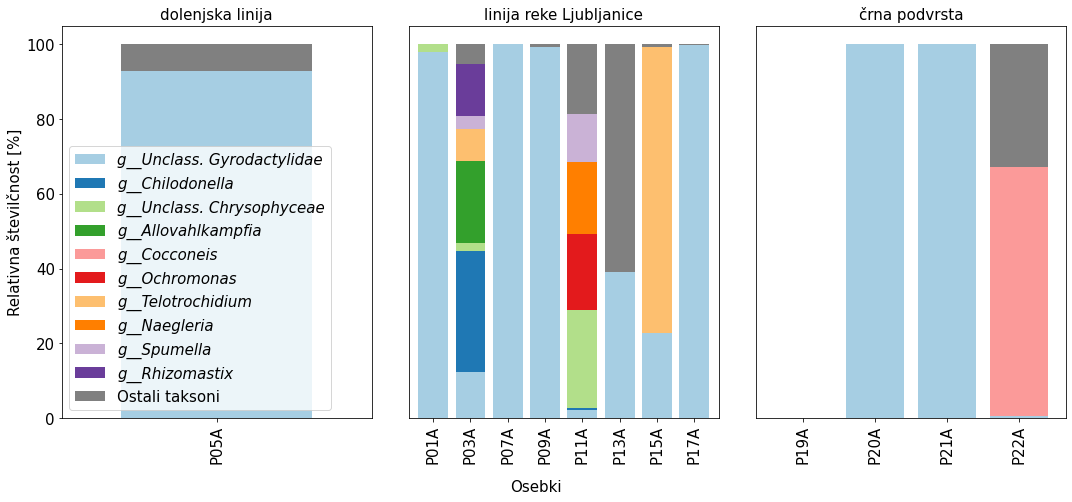

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(15, 7))

max_count = 11
groups = ['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta']
kwargs = dict(level=6, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.Paired.colors)
colors[max_count-1] = 'gray'

for i, group in enumerate(groups):
    ax = axes[i]
    dokdo.taxa_abundance_bar_plot(
        taxa_bar_plot,
        ax=ax,
        colors=colors,
        include_samples={'population': [group]},
        legend_short=True,
        exclude_taxa=taxa_to_remove,
        legend=True if i == 0 else False,
        **kwargs # da razbije dictionary se uporabi **
    )
    if i != 0:
        ax.get_yaxis().set_visible(False)
    ax.set_title(group)

# custom properties    
fig.supxlabel('Osebki', fontsize = 15)
axes[0].set_ylabel('Relativna številčnost [%]')

h, l = axes[0].get_legend_handles_labels()
l[-1] = 'Ostali taksoni'

legend = axes[0].legend(h, l, prop={'size': 15, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')    

for idx, ax in enumerate(axes):
    ax.tick_params(axis='x', labelrotation = 90, labelsize=15)  # reset rotation
    ax.tick_params(axis='y', labelsize=15)
    ax.yaxis.label.set_size(15)
    ax.title.set_size(15)
    
plt.tight_layout()
plt.savefig('./results/proteus_all_populations_eukarya.png')

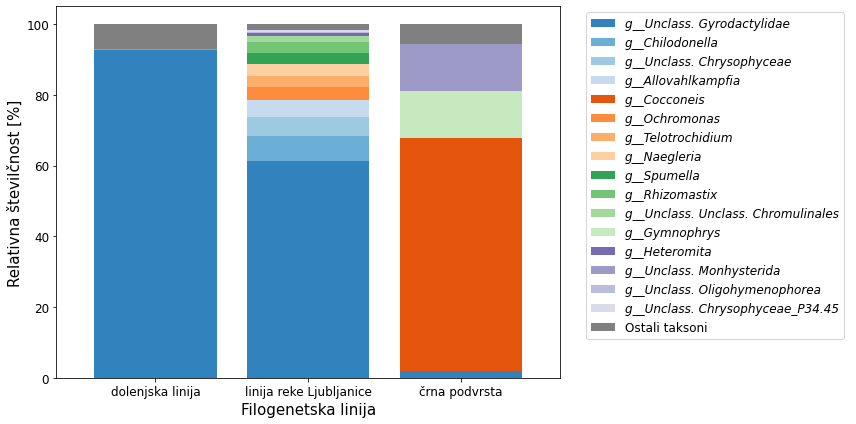

In [44]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [3, 1]})

max_count = 17
kwargs = dict(level=6, count=max_count, sort_by_mean2=False)

colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax1,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    exclude_taxa=taxa_to_remove,
    legend=False,
    colors=colors,
    **kwargs
)

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    ax=ax2,
    group='population',
    group_order=['dolenjska linija', 'linija reke Ljubljanice', 'črna podvrsta'],
    figsize=(10, 7),
    exclude_taxa=taxa_to_remove,
    legend_short=True,
    colors=colors,
    **kwargs
)

# custom properties    
ax1.set_xlabel('Filogenetska linija', fontsize = 15)
ax1.set_ylabel('Relativna številčnost [%]')

handles, labels = ax2.get_legend_handles_labels()
labels[-1] = 'Ostali taksoni'

ax2.clear()
legend = ax2.legend(handles, labels, prop={'size': 12, 'style': 'italic'})
legend.get_texts()[-1].set_style('normal')
ax2.axis('off')

ax1.tick_params(labelrotation = 0, labelsize=12)  # reset rotation
ax1.yaxis.label.set_size(15)

plt.tight_layout()
plt.savefig('./results/populations_together_euk.png')

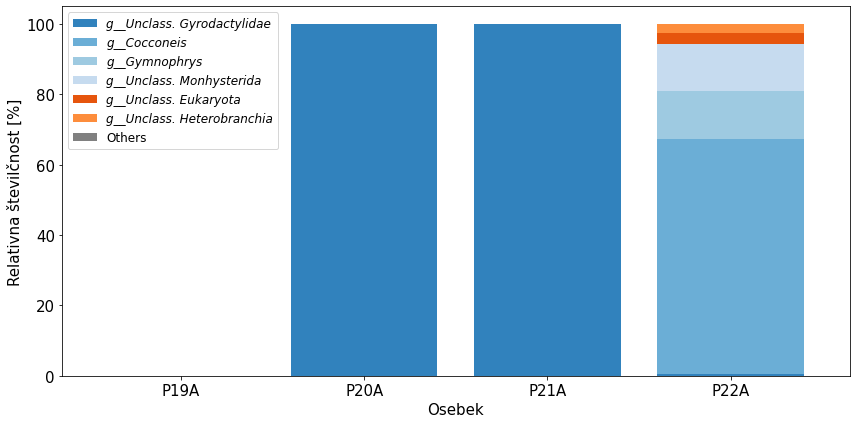

In [45]:
max_count = 7

kwargs = dict(
    include_samples={'population': ['črna podvrsta']},
    label_columns=['sample-id'],
    level=6,
    count=max_count,
)

colors = list(plt.cm.tab20c.colors)
colors[max_count-1] = 'gray'

fig, ax = plt.subplots(figsize=(12, 6))

dokdo.taxa_abundance_bar_plot(
    taxa_bar_plot,
    figsize=(12, 6),
    exclude_taxa=taxa_to_remove,
    colors=colors,
    legend_short=True,
    ax=ax,
    **kwargs
)

handles, labels = ax.get_legend_handles_labels()

ax.tick_params(labelrotation = 0, labelsize=15) 
ax.yaxis.label.set_size(15)
ax.xaxis.label.set_size(15)
legend = ax.legend(handles, labels, prop={'size': 12,'style': 'italic'})
legend.get_texts()[-1].set_style('normal')

ax.set_xlabel('Osebek', fontsize = 15)
ax.set_ylabel('Relativna številčnost [%]')

plt.tight_layout()
plt.savefig('./results/crni_primerjava10najpogostejsih_euk.png')